# Gradient Boosting

Le notebook explore l'algorithme du [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting).

In [5]:
%matplotlib inline

## Premier exemple

On considère les paramètres par défaut de la classe [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor).

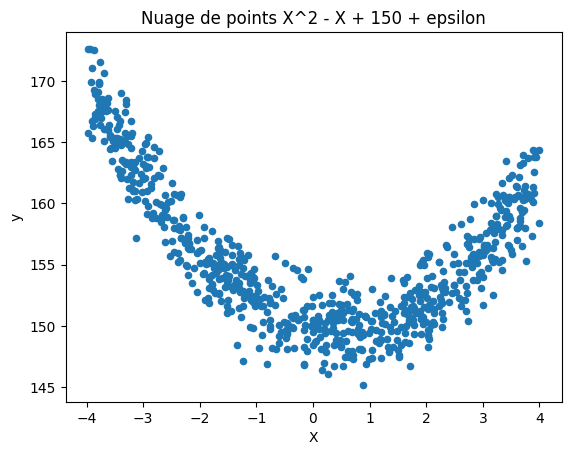

In [6]:
from numpy.random import randn, random
from pandas import DataFrame
from sklearn.model_selection import train_test_split

rnd = randn(1000)
X = random(1000) * 8 - 4
y = X**2 - X + rnd * 2 + 150  # X^2 - X + 150 + epsilon
X = X.reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y)
df = DataFrame({"X": X_train.ravel(), "y": y_train})
ax = df.plot(x="X", y="y", kind="scatter")
ax.set_title("Nuage de points X^2 - X + 150 + epsilon");

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth=1)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1)

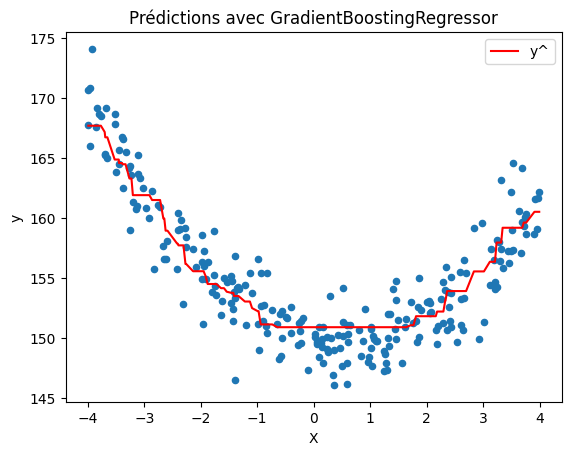

In [8]:
import numpy

ind = numpy.argsort(X_test, axis=0)
y_ = model.predict(X_test)
df = DataFrame(
    {"X": X_test[ind].ravel(), "y": y_test[ind].ravel(), "y^": y_[ind].ravel()}
)
ax = df.plot(x="X", y="y", kind="scatter")
df.plot(x="X", y="y^", kind="line", ax=ax, color="r")
ax.set_title("Prédictions avec GradientBoostingRegressor");

Rien d'imprévu jusque là. Essayons autre chose. On regarde avec une seule itération.

In [9]:
model = GradientBoostingRegressor(max_depth=1, n_estimators=1, learning_rate=0.5)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=1, n_estimators=1)

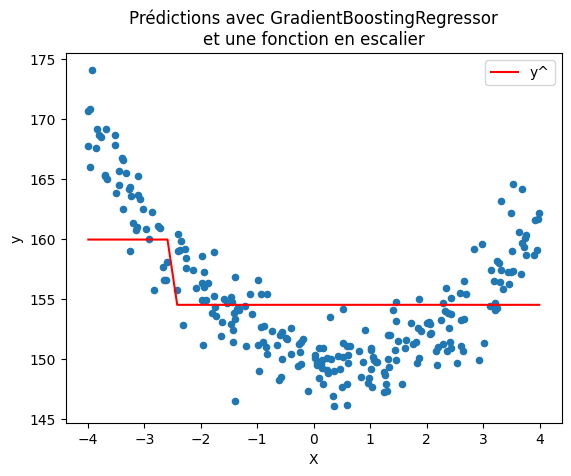

In [10]:
y_ = model.predict(X_test)
df = DataFrame(
    {"X": X_test[ind].ravel(), "y": y_test[ind].ravel(), "y^": y_[ind].ravel()}
)
ax = df.plot(x="X", y="y", kind="scatter")
df.plot(x="X", y="y^", kind="line", ax=ax, color="r")
ax.set_title("Prédictions avec GradientBoostingRegressor\net une fonction en escalier");

Essayons de montrer l'évolution de la courbe prédite en fonction du nombre de marches et revenons à 100 estimateurs.

In [11]:
model = GradientBoostingRegressor(max_depth=1)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1)

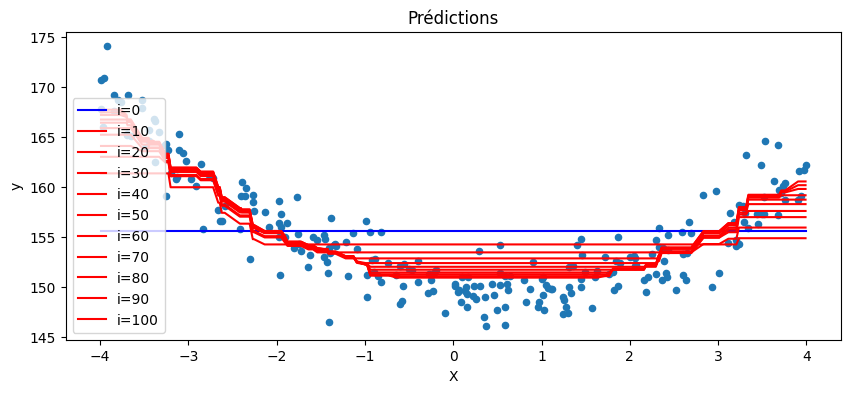

In [12]:
for i in range(0, model.estimators_.shape[0] + 1, 10):
    if i == 0:
        df = DataFrame({"X": X_test[ind].ravel(), "y": y_test[ind].ravel()})
        ax = df.plot(x="X", y="y", kind="scatter", figsize=(10, 4))
        y_ = model.init_.predict(X_test)
        color = "b"
    else:
        y_ = sum(
            [model.init_.predict(X_test),
            *[
                model.estimators_[k, 0].predict(X_test) * model.learning_rate
                for k in range(0, i)
            ]]
        )
        color = "r"
    df = DataFrame({"X": X_test[ind].ravel(), "y^": y_[ind].ravel()})
    df.plot(x="X", y="y^", kind="line", ax=ax, color=color, label="i=%d" % i)
ax.set_title("Prédictions");

## learning rate et itérations

Et si on choisissait un *learning_rate*, plus petit ou plus grand...

In [13]:
model01 = GradientBoostingRegressor(max_depth=1, learning_rate=0.01)
model01.fit(X_train, y_train)
modela = GradientBoostingRegressor(max_depth=1, learning_rate=1.2)
modela.fit(X_train, y_train)
modelb = GradientBoostingRegressor(max_depth=1, learning_rate=1.99)
modelb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.99, max_depth=1)

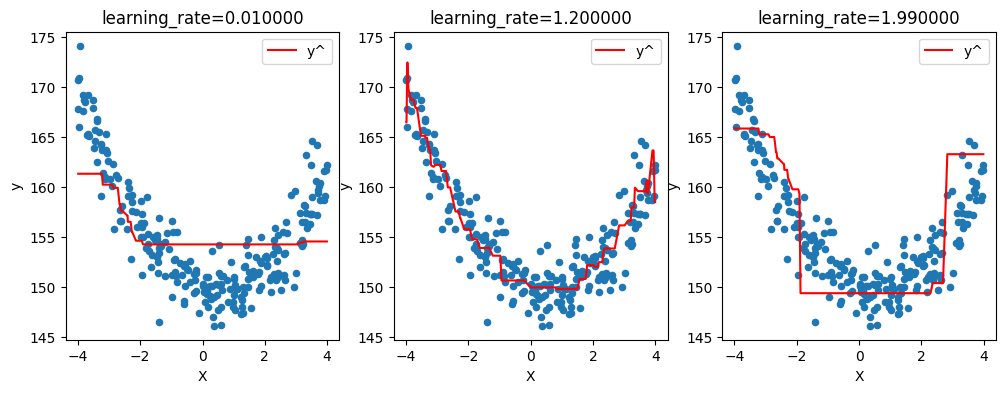

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ind = numpy.argsort(X_test, axis=0)

for i, mod in enumerate([model01, modela, modelb]):
    df = DataFrame(
        {
            "X": X_test[ind].ravel(),
            "y": y_test[ind].ravel(),
            "y^": mod.predict(X_test)[ind].ravel(),
        }
    )
    df.plot(x="X", y="y", kind="scatter", ax=ax[i])
    df.plot(x="X", y="y^", kind="line", ax=ax[i], color="r")
    ax[i].set_title("learning_rate=%f" % mod.learning_rate);

Une trop faible valeur de *learning_rate* semble retenir le modèle de converger, une grande valeur produit des effets imprévisibles. Pour comprendre pourquoi, il faut détailler l'algorithme...

## L'algorithme

### Inspiration


L'algorithme est inspiré de l'algorithme de la descente de gradient. On considère une fonction réelle $f(x)$ et on calcule le gradient $\frac{\partial f}{\partial x}(x)$ pour construire une suite :

$$x_{t+1} = x_t - \epsilon_t \frac{\partial f}{\partial x}(x_t)$$

La suite $(x_t)$ converge vers le minimum de la fonction $f$. On applique cela à une fonction d'erreur issue d'un problème de régression.

$$f(x) = \sum_{n=1}^N l(F(X_i), y_i)$$

Le plus souvent, on applique cette méthode à une fonction $F$ qui dépend d'un paramètre $\theta$

$$f(\theta, x) = \sum_{n=1}^N l(F(\theta, X_i), y_i)$$

Et c'est la suite $\theta_{t+1} = \theta_t - \epsilon_t \frac{\partial f}{\partial \theta}(\theta_t)$ qui converge vers le minimum de la fonction $f$ de sorte que la fonction $f(\theta, x)$ approxime au mieux les points $(X_i, y_i)$. Mais, on pourrait tout-à-fait résoudre ce problème dans un espace de fonctions et non un espace de paramètres :

$$G_{t+1} = G_t - \epsilon_t \frac{\partial f}{\partial G}(G_t)$$

Le gradient $\frac{\partial f}{\partial G}$ est facile à calculer puisqu'il ne dépend pas de $G$. On pourrait donc construire la fonction de régression $G$ comme une suite additive de fonctions $F_k \sim - \epsilon_t \frac{\partial f}{\partial G}(G_t)$. 

$$G_t = \sum_{k=1}^t F_k$$

Et nous pourrions construire la fonction $F_k$ comme solution d'un problème de régression défini par les couples $(X_i, z_i)$ avec :

$$\begin{array}{rcl} z_i &=& - \epsilon_t \frac{\partial f}{\partial G}(G_t(X_i), y_i) \\ f(X_i, y_i) &=& l(G_t(X_i), y_i)\end{array}$$

Voilà l'idée.

### Algorithme

Je reprends ici la page wikipedia. On cherche à construire un modèle qui minimise l'erreur $L(y,F(x)) = \sum_{i=1}^n l(y_i, F(X_i))$. On note $r$ le learning rate.

**Etape 1 :** on cale un premier modèle de régression, ici, simplement une constante, en optimisant $F_0(x) = \arg \min_\gamma \sum_{i=1}^n L(y_i, \gamma)$. $F_0(x)$ est une constante.

On note ensuite $F_m(x) = \gamma_0 \sum_{k=1}^m r \gamma_k h_k(x)$ où $\gamma_0$ est la fonction constante construire lors de la première étape.

**Etape 2 :** on calcule ensuite les erreurs $e_{im} = l(y_i, F_m(x_i))$ et l'opposé du gradient $r_{im} = - \left[ \frac{\partial l(y_i, F_m(x_i)) }{\partial F_m(x_i)} \right]$

**Etape 3 :** on choisit la fonction $h_{m+1}(x)$ de telle sorte qu'elle approxime au mieux les résidus $r_{im}$.

**Etape 4 :** on choisit le coefficient $\gamma_{m+1}$ de telle sorte qu'il minimise l'expression $\min_\gamma \sum_{i=1}^n l\left(y_i, \gamma_0 + \sum_{k=1}^m r \gamma_k h_k(x_i) + \gamma h_{m+1}(x_i)\right)$.

On retourne l'étape 2 autant de fois qu'il y a d'itérations. Lorsque l'erreur est une erreur quadratique $l(y, F(x)) = (y-F(x))^2$, les résidus deviennent $r_{im} = -2 (y_i - F_m(x_i))$. Par conséquent, la fonction $h$ approxime au mieux ce qu'il manque pour atteindre l'objectif. Un learning rate égal à 1 fait que la somme des prédictions de chaque fonction $h_m$ oscille autour de la vraie valeur, une faible valeur donne l'impression d'une fonction qui converge à petits pas, une grande valeur accroît l'amplitude des oscillations au point d'empêcher l'algorithme de converger.

On voit aussi que l'algorithme s'intéresse d'abord aux points où le gradient est le plus fort, donc en principe aux erreurs les plus grandes.

## Régression quantile

Dans ce cas, l'erreur quadratique est remplacée par une erreur en valeur absolue. Les résidus dans ce cas sont égaux à -1 ou 1.

In [15]:
alpha = 0.5
model = GradientBoostingRegressor(
    alpha=alpha, loss="quantile", max_depth=1, learning_rate=0.1
)
model.fit(X_train, y_train)
model01 = GradientBoostingRegressor(
    alpha=alpha, loss="quantile", max_depth=1, learning_rate=0.01
)
model01.fit(X_train, y_train)
modela = GradientBoostingRegressor(
    alpha=alpha, loss="quantile", max_depth=1, learning_rate=1.2
)
modela.fit(X_train, y_train)
modelb = GradientBoostingRegressor(
    alpha=alpha, loss="quantile", max_depth=1, learning_rate=1.99
)
modelb.fit(X_train, y_train)
modelc = GradientBoostingRegressor(
    alpha=alpha, loss="quantile", max_depth=1, learning_rate=2.01
)
modelc.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5, learning_rate=2.01, loss='quantile',
                          max_depth=1)

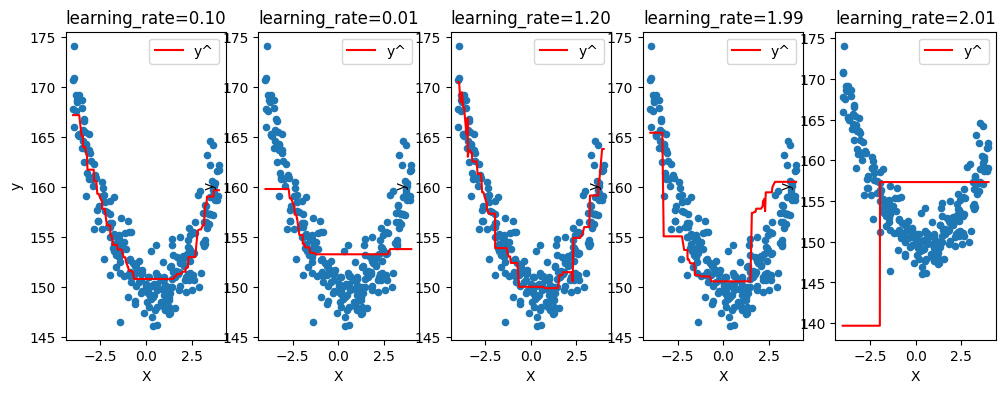

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
ind = numpy.argsort(X_test, axis=0)

for i, mod in enumerate([model, model01, modela, modelb, modelc]):
    df = DataFrame(
        {
            "X": X_test[ind].ravel(),
            "y": y_test[ind].ravel(),
            "y^": mod.predict(X_test)[ind].ravel(),
        }
    )
    df.plot(x="X", y="y", kind="scatter", ax=ax[i])
    df.plot(x="X", y="y^", kind="line", ax=ax[i], color="r")
    ax[i].set_title("learning_rate=%1.2f" % mod.learning_rate);

Concrètement, le paramètre *max_depth=1* correspond à une simple fonction $f(x) = \mathbb{1}_{x > s}$ et le modèle final est une somme pondérée de fonctions indicatrices.

## learning_rate et sur-apprentissage

In [41]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm


def experiment(models, tries=25):
    scores = []
    for _ in tqdm(range(tries)):
        rnd = randn(1000)
        X = random(1000) * 8 - 4
        y = X**2 - X + rnd * 2 + 150  # X^2 - X + 150 + epsilon
        X = X.reshape((-1, 1))
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        scs = []
        for model in models:
            model.fit(X_train, y_train)
            sc = model.score(X_test, y_test)
            scs.append(sc)
        scores.append(scs)
    return scores


scores = experiment(
    [
        GradientBoostingRegressor(max_depth=1, n_estimators=20),
        RandomForestRegressor(max_depth=1, n_estimators=20),
    ]
)
scores[:3]

100%|██████████| 25/25 [00:01<00:00, 15.47it/s]


[[0.6061998151266149, 0.5241640887093781],
 [0.6865162453017377, 0.5868617679417452],
 [0.6643588529036899, 0.5882688129311655]]

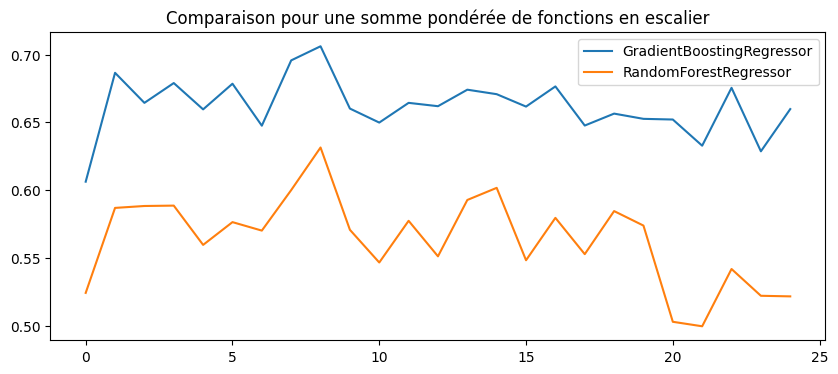

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="GradientBoostingRegressor")
ax.plot([_[1] for _ in scores], label="RandomForestRegressor")
ax.set_title("Comparaison pour une somme pondérée de fonctions en escalier")
ax.legend();

Ce résultat est attendu car la forêt aléatoire est une moyenne de modèle de régression tous appris dans les mêmes conditions alors que le gradient boosting s'intéresse à l'erreur après la somme des premiers régresseurs. Voyons avec des arbres de décision et non plus des fonctions en escaliers.

In [43]:
from sklearn.tree import DecisionTreeRegressor

scores = experiment(
    [
        GradientBoostingRegressor(max_depth=5, n_estimators=20),
        RandomForestRegressor(max_depth=5, n_estimators=20),
        DecisionTreeRegressor(max_depth=5),
    ]
)

100%|██████████| 25/25 [00:02<00:00, 11.19it/s]


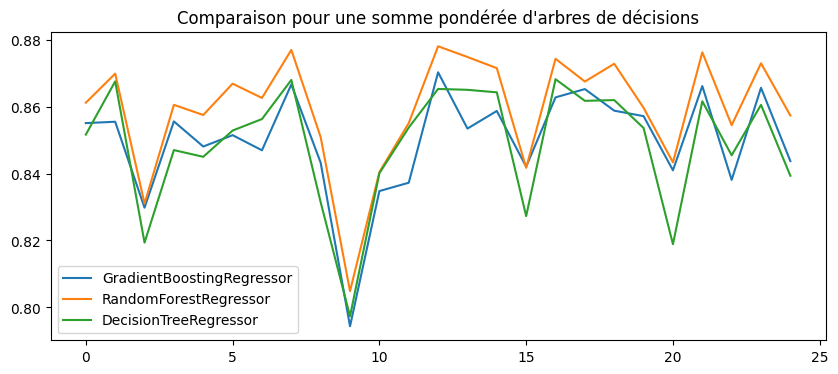

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="GradientBoostingRegressor")
ax.plot([_[1] for _ in scores], label="RandomForestRegressor")
ax.plot([_[2] for _ in scores], label="DecisionTreeRegressor")
ax.set_title("Comparaison pour une somme pondérée d'arbres de décisions")
ax.legend();

Le modèle *GradientBoostingRegressor* est clairement moins bon quand le modèle sous-jacent - l'arbre de décision - est performant. On voit que la forêt aléatoire est meilleure qu'un arbre de décision seul. Cela signifie qu'elle généralise mieux et que l'arbre de décision fait du sur apprentissage. De même, le *GradientBoostingRegressor* est plus exposé au sur-apprentissage.

In [47]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        GradientBoostingRegressor(max_depth=5, n_estimators=20, learning_rate=0.05),
        GradientBoostingRegressor(max_depth=5, n_estimators=20, learning_rate=0.1),
        GradientBoostingRegressor(max_depth=5, n_estimators=20, learning_rate=0.2),
    ]
)
scores[:2]

100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


[[0.8505309865561821,
  0.7409584480906592,
  0.8372610096704007,
  0.8433616064058848],
 [0.8610474948662841,
  0.7463887159097458,
  0.8469931884879516,
  0.8553184433763386]]

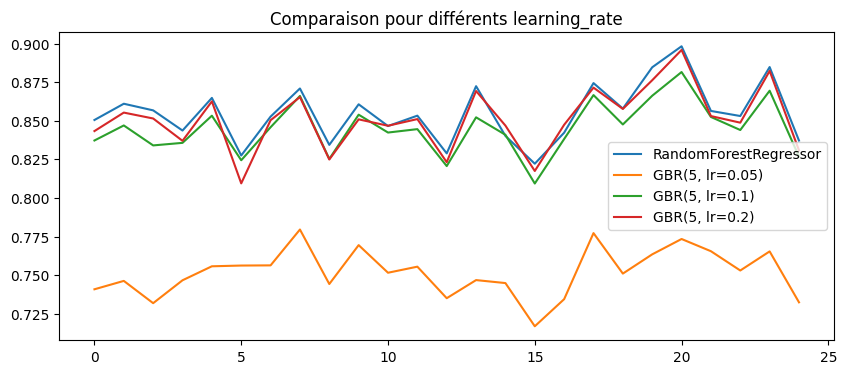

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor")
ax.plot([_[1] for _ in scores], label="GBR(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="GBR(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="GBR(5, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate")
ax.legend();

Diminuer *learning_rate* est clairement une façon d'éviter le sur-apprentissage mais les graphes précédents ont montré qu'il fallait plus d'itérations lorsque le learning rate est petit.

In [49]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        GradientBoostingRegressor(max_depth=1, n_estimators=20, learning_rate=0.05),
        GradientBoostingRegressor(max_depth=1, n_estimators=20, learning_rate=0.1),
        GradientBoostingRegressor(max_depth=1, n_estimators=20, learning_rate=0.2),
    ]
)
scores[:2]

100%|██████████| 25/25 [00:02<00:00,  8.43it/s]


[[0.8595510594071162,
  0.47103349192372335,
  0.6460977028277105,
  0.7953273631823825],
 [0.8418307915852581,
  0.4894523688410177,
  0.6494948729040753,
  0.7754015641398699]]

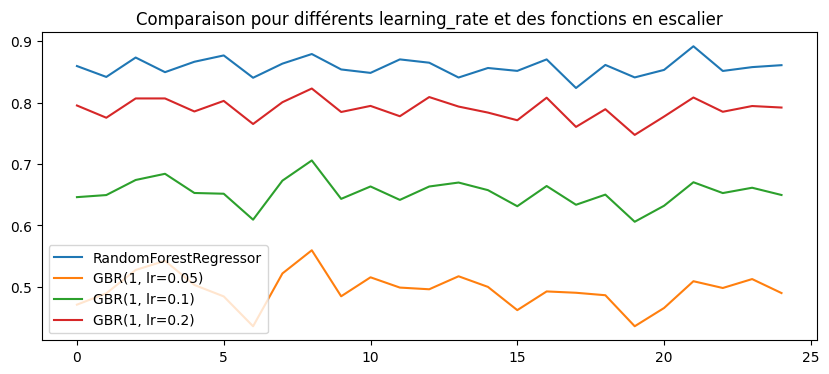

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor")
ax.plot([_[1] for _ in scores], label="GBR(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="GBR(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="GBR(1, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate et des fonctions en escalier")
ax.legend();

Plus le modèle sous-jacent est simple, plus le *learning_rate* peut être élevé car les modèles simples ne font pas de sur-apprentissage.

## Gradient Boosting avec d'autres librairies

Une somme pondérée de régression linéaire reste une regréssion linéaire. Il est impossible de tester ce scénario avec *scikit-learn* puisque seuls les arbres de décisions sont implémentés. Mais il existe d'autres librairies qui implémente le gradient boosting.

### XGBoost

In [51]:
from xgboost import XGBRegressor

In [52]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        XGBRegressor(
            max_depth=1,
            n_estimators=20,
            learning_rate=0.05,
            objective="reg:squarederror",
        ),
        XGBRegressor(
            max_depth=1,
            n_estimators=20,
            learning_rate=0.1,
            objective="reg:squarederror",
        ),
        XGBRegressor(
            max_depth=1,
            n_estimators=20,
            learning_rate=0.2,
            objective="reg:squarederror",
        ),
    ]
)
scores[:2]

100%|██████████| 25/25 [00:02<00:00,  9.09it/s]


[[0.8362392926836479,
  0.5284643193472292,
  0.6696397339277518,
  0.7786586369744302],
 [0.8866993680319293,
  0.5135892626305283,
  0.6803157400434685,
  0.8171169617436257]]

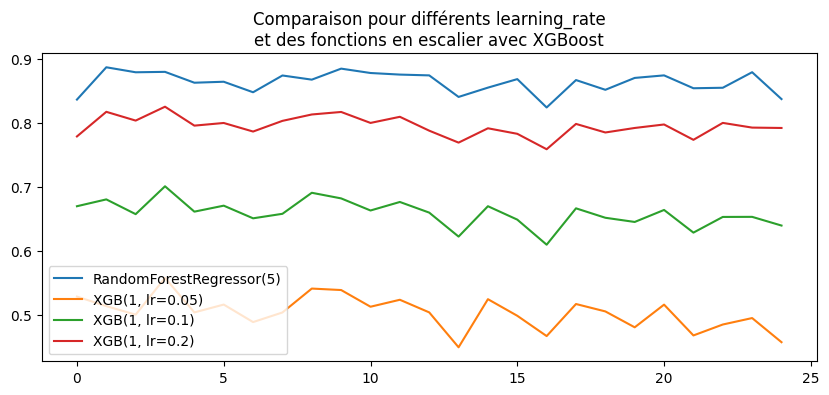

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="XGB(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="XGB(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="XGB(1, lr=0.2)")
ax.set_title(
    "Comparaison pour différents learning_rate\net des fonctions en escalier "
    "avec XGBoost"
)
ax.legend();

Les résultats sont sensiblement les mêmes.

In [54]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        XGBRegressor(
            max_depth=5,
            n_estimators=20,
            learning_rate=0.05,
            objective="reg:squarederror",
        ),
        XGBRegressor(
            max_depth=5,
            n_estimators=20,
            learning_rate=0.1,
            objective="reg:squarederror",
        ),
        XGBRegressor(
            max_depth=5,
            n_estimators=20,
            learning_rate=0.2,
            objective="reg:squarederror",
        ),
    ]
)
scores[:2]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


[[0.8590132304552919,
  0.7402716733771284,
  0.8482110599066995,
  0.8642576634357626],
 [0.8599672573344654,
  0.7367047036233907,
  0.84659652680362,
  0.8606710003826832]]

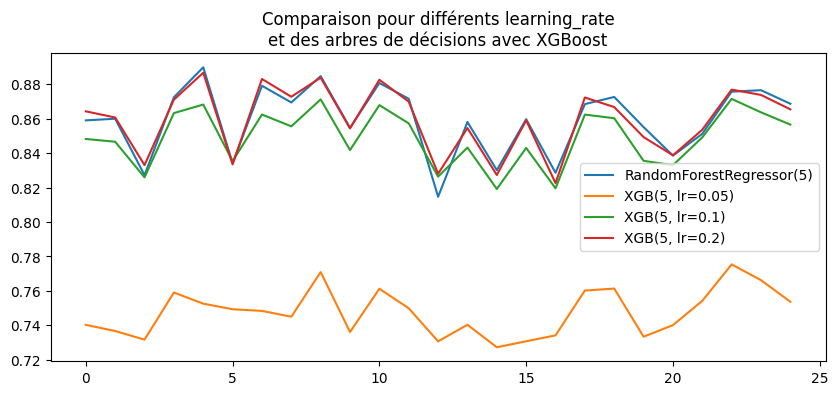

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="XGB(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="XGB(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="XGB(5, lr=0.2)")
ax.set_title(
    "Comparaison pour différents learning_rate\net des arbres de décisions "
    "avec XGBoost"
)
ax.legend();

### LightGbm

In [30]:
from lightgbm import LGBMRegressor

In [56]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        LGBMRegressor(max_depth=1, n_estimators=20, learning_rate=0.05),
        LGBMRegressor(max_depth=1, n_estimators=20, learning_rate=0.1),
        LGBMRegressor(max_depth=1, n_estimators=20, learning_rate=0.2),
    ]
)
scores[:2]

  8%|▊         | 2/25 [00:00<00:02, 10.71it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.276912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.276912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750

 24%|██▍       | 6/25 [00:00<00:01, 12.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.434819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.434819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training fr

 32%|███▏      | 8/25 [00:00<00:01, 13.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.458236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.458236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750

 48%|████▊     | 12/25 [00:00<00:01, 12.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.536138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.536138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750

 56%|█████▌    | 14/25 [00:01<00:00, 11.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.396002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.396002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training fr

 72%|███████▏  | 18/25 [00:01<00:00, 12.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 154.999049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 154.999049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training fr

 80%|████████  | 20/25 [00:01<00:00, 12.98it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.189666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.189666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750

 96%|█████████▌| 24/25 [00:01<00:00, 13.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.240350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.240350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750

100%|██████████| 25/25 [00:01<00:00, 12.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.386138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.386138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training fr

[[0.8773032128441518,
  0.48214820701023675,
  0.6539572474605444,
  0.7984627882777451],
 [0.8555575315832163,
  0.4977691173485087,
  0.6367319006906368,
  0.7683900978469463]]

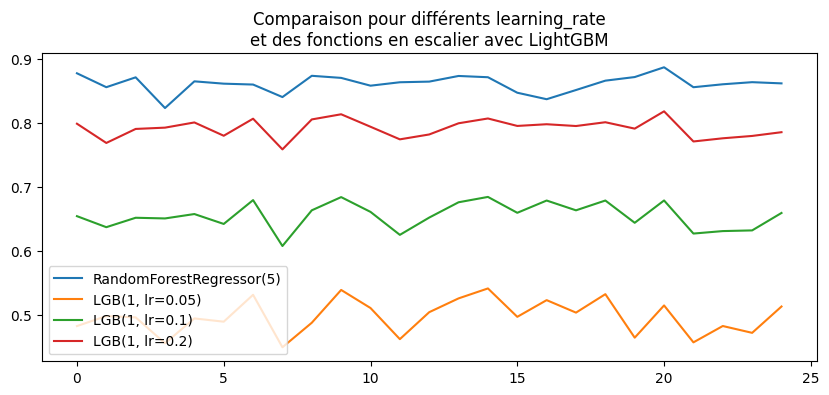

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="LGB(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="LGB(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="LGB(1, lr=0.2)")
ax.set_title(
    "Comparaison pour différents learning_rate\net des fonctions en escalier "
    "avec LightGBM"
)
ax.legend();

In [58]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        LGBMRegressor(max_depth=5, n_estimators=20, learning_rate=0.05),
        LGBMRegressor(max_depth=5, n_estimators=20, learning_rate=0.1),
        LGBMRegressor(max_depth=5, n_estimators=20, learning_rate=0.2),
    ]
)
scores[:2]

  8%|▊         | 2/25 [00:00<00:02,  8.95it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.156120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 16%|█▌        | 4/25 [00:00<00:02, 10.20it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.345161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

 24%|██▍       | 6/25 [00:00<00:01, 10.88it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.600185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 32%|███▏      | 8/25 [00:00<00:01, 10.56it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.414976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

 40%|████      | 10/25 [00:01<00:01,  9.77it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.312694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 48%|████▊     | 12/25 [00:01<00:01, 10.15it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 56%|█████▌    | 14/25 [00:01<00:01,  9.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

 60%|██████    | 15/25 [00:01<00:01,  8.81it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.140242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

 72%|███████▏  | 18/25 [00:01<00:00,  8.19it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.432455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 80%|████████  | 20/25 [00:02<00:00,  9.29it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.163655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 88%|████████▊ | 22/25 [00:02<00:00,  7.86it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.444763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 25/25 [00:02<00:00,  9.30it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 1
[LightGBM] [Info] Start training from score 155.162133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[[0.8384828369380417,
  0.7470535641154521,
  0.8395674441554806,
  0.8460697933405346],
 [0.8966181473711606,
  0.7767690018820292,
  0.8808463799894176,
  0.8937462469421166]]

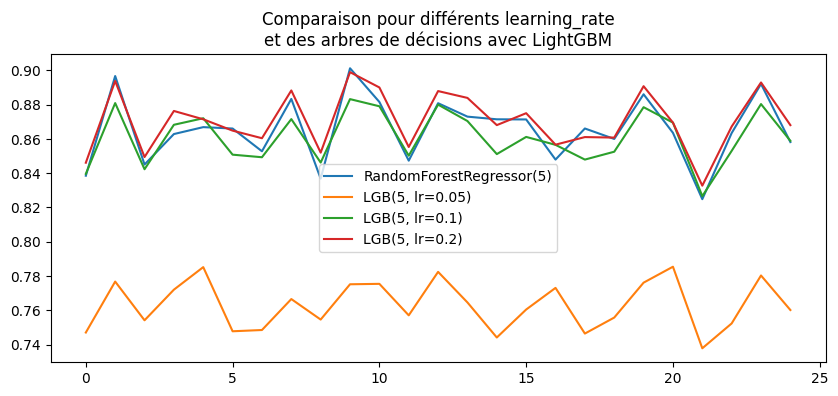

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="LGB(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="LGB(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="LGB(5, lr=0.2)")
ax.set_title(
    "Comparaison pour différents learning_rate\net des arbres de décisions "
    "avec LightGBM"
)
ax.legend();

[LightGBM](https://lightgbm.readthedocs.io/en/latest/) paraît moins sensible au *learning_rate* que [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html).

### CatBoost

[CatBoost](https://catboost.ai/) est une des plus récentes. Elle est sensée être plus efficace pour les catégories ce qui n'est pas le cas ici.

In [60]:
from catboost import CatBoostRegressor

In [61]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        CatBoostRegressor(
            max_depth=1, n_estimators=20, learning_rate=0.05, verbose=False
        ),
        CatBoostRegressor(
            max_depth=1, n_estimators=20, learning_rate=0.1, verbose=False
        ),
        CatBoostRegressor(
            max_depth=1, n_estimators=20, learning_rate=0.2, verbose=False
        ),
    ]
)
scores[:2]

100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


[[0.8878458732034202,
  0.5106308809971148,
  0.6633876012158881,
  0.7962100349534728],
 [0.8702333178716275,
  0.47507766677086194,
  0.632648027686756,
  0.7779024827838191]]

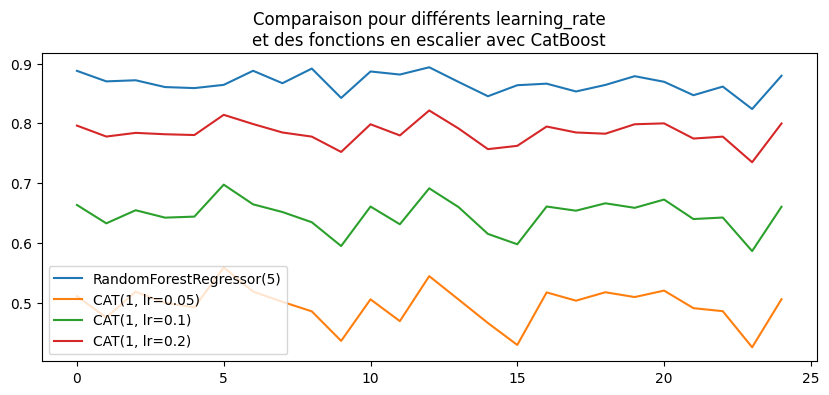

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="CAT(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="CAT(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="CAT(1, lr=0.2)")
ax.set_title(
    "Comparaison pour différents learning_rate\net des fonctions en escalier "
    "avec CatBoost"
)
ax.legend();

In [63]:
scores = experiment(
    [
        RandomForestRegressor(max_depth=5, n_estimators=20),
        CatBoostRegressor(
            max_depth=5, n_estimators=20, learning_rate=0.05, verbose=False
        ),
        CatBoostRegressor(
            max_depth=5, n_estimators=20, learning_rate=0.1, verbose=False
        ),
        CatBoostRegressor(
            max_depth=5, n_estimators=20, learning_rate=0.2, verbose=False
        ),
    ]
)
scores[:2]

100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


[[0.8605624010619503,
  0.7022983070352993,
  0.8366211999791443,
  0.8636015275401271],
 [0.8456129223719402,
  0.7027514870740816,
  0.8333140676555679,
  0.8596728951071267]]

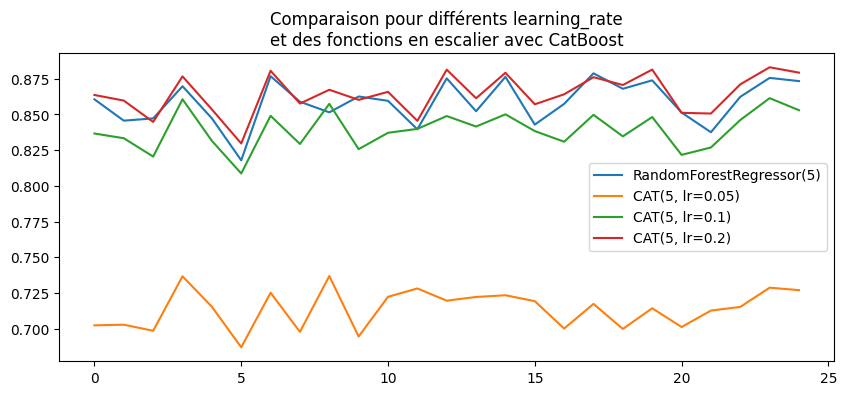

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="CAT(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="CAT(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="CAT(5, lr=0.2)")
ax.set_title(
    "Comparaison pour différents learning_rate\net des fonctions en escalier "
    "avec CatBoost"
)
ax.legend();